# Random Walk

Let's suppose we have a random walk process defined by
$$
x(t+1) = x(t) + 2 \varepsilon - 1, \; \; \; \; \varepsilon \sim \mathrm{Bernoulli}(p)
$$
where $p$ is the probability of doing a step forward.

In this notebook, we create some synthetic data for a value of $p$ and we try to recover it through inference.

In [1]:
from birds.models.random_walk import RandomWalk
from birds.calibrator import Calibrator

import torch
import matplotlib.pyplot as plt
import pandas as pd

## Generating synthetic data

In [2]:
rw = RandomWalk(n_timesteps=100)

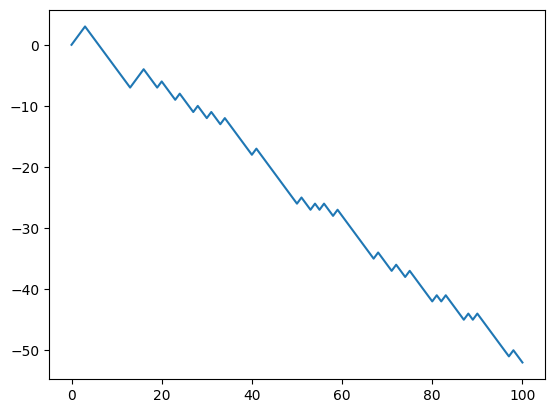

In [3]:
true_data = rw.observe(rw.run(torch.tensor([0.25])))

plt.plot(true_data[0].numpy())

## Defining the calibrator

Here we assume that the posterior distribution has a gaussian form, so we need to implement a parametrized gaussian that contains the `sample`,  and `log_prob` methods.
Note that the `sample` methods needs to propagate the gradient, so it is equivalent to the `rsample` method in PyTorch distributions.

In [4]:
class TrainableGaussian(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Parameter(0.5 * torch.ones(1))
        self.sigma = torch.nn.Parameter(0.1 * torch.ones(1))

    def log_prob(self, x):
        sigma = torch.clip(self.sigma, min=1e-3)
        return torch.distributions.Normal(self.mu, sigma).log_prob(x)

    def sample(self, x):
        sigma = torch.clip(self.sigma, min=1e-3)
        dist = torch.distributions.Normal(self.mu, sigma)
        sample = dist.rsample((x,)) 
        return sample, dist.log_prob(sample)


Notice that we clip $\sigma$ to prevent unphysical values. All we need to do know is to specify a prior and initialize the calibrator. Other optional arguments are described here:

In [5]:
?Calibrator

Init signature:
Calibrator(
    model: birds.models.model.Model,
    prior: torch.distributions.distribution.Distribution,
    posterior_estimator: torch.nn.modules.module.Module,
    data: List[torch.Tensor],
    w: float = 0.0,
    gradient_clipping_norm: float = inf,
    forecast_loss: Optional[Callable] = None,
    optimizer: torch.optim.optimizer.Optimizer | None = None,
    n_samples_per_epoch: int = 5,
    n_samples_regularisation: int = 10000,
    diff_mode: str = 'reverse',
    gradient_estimation_method: str = 'pathwise',
    jacobian_chunk_size: int | None = None,
    gradient_horizon: int = 0,
    device: str = 'cpu',
    progress_bar: bool = True,
    log_tensorboard: bool = False,
    tensorboard_log_dir: str | None = None,
)
Docstring:     
Class that handles the training of the posterior_estimator given the model, data, and prior.

**Arguments:**

- `model`: The simulator model.
- `prior`: The prior distribution.
- `posterior_estimator`: The variational distribution tha

In [6]:
posterior_estimator = TrainableGaussian()
prior = torch.distributions.Normal(0, 1)
optimizer = torch.optim.Adam(posterior_estimator.parameters(), 1e-2)

calibrator = Calibrator(model = rw, posterior_estimator=posterior_estimator, prior=prior, data=true_data, optimizer=optimizer, w = 10.0)

In [7]:
# we can now train the estimator for a 100 epochs
calibrator.run(100, max_epochs_without_improvement=100)

100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.96it/s, Forecast=41.1, Reg.=36.8, total=77.9, best loss=52, epochs since improv.=5]


The model stops when it hits a certain amount of epochs without improvement.
The run function returns the loss per epoch as well as the best model weights.
Let's have a look at the loss first:

In [8]:
df = pd.DataFrame(calibrator.losses_hist)
df.head()

,total,forecast,regularisation
0,714.693481,695.279236,19.414228
1,905.253479,884.902954,20.350531
2,471.038513,449.576233,21.462278
3,885.274902,863.556458,21.718418
4,605.862061,583.873230,21.988831


<Axes: >

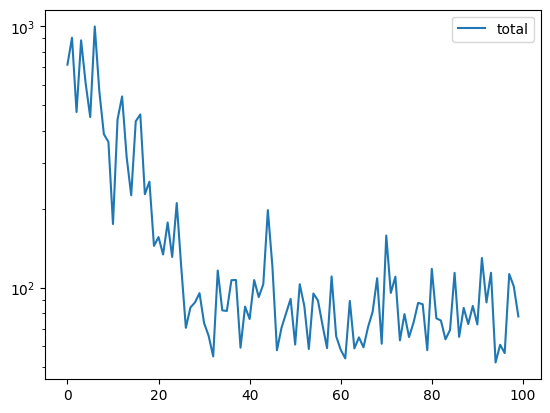

In [9]:
df.plot(y="total", logy=True)

In [10]:
# We can now load the best model
posterior_estimator.load_state_dict(calibrator.best_model_state_dict)

<All keys matched successfully>

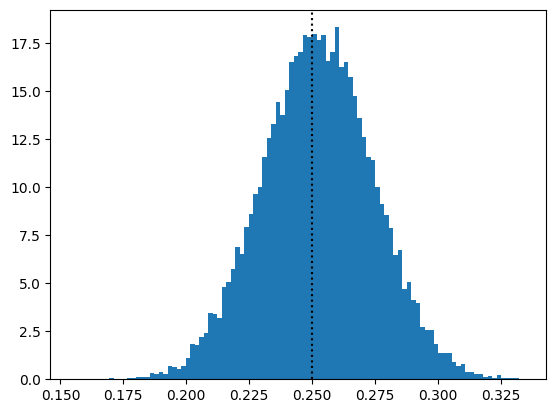

In [11]:
# and plot the posterior
with torch.no_grad():
    samples = posterior_estimator.sample(20000)[0].flatten().cpu()
plt.hist(samples, density=True, bins=100);
plt.axvline(0.25, label = "true value", color = "black", linestyle=":")

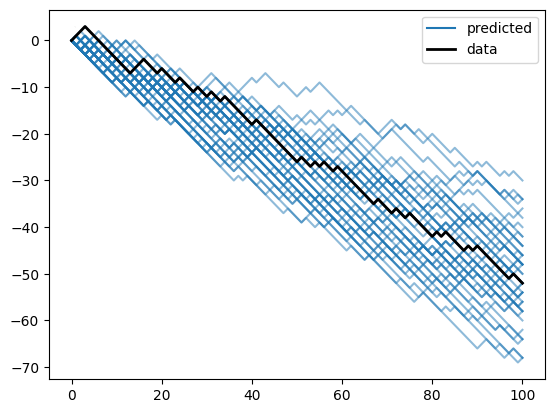

In [12]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(50):
    with torch.no_grad():
        sim_rw = rw.observe(rw.run(posterior_estimator.sample(1)[0]))[0].numpy()
    ax.plot(sim_rw, color = "C0", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted")
ax.plot(true_data[0], color = "black", linewidth=2, label = "data")

ax.legend()